In [3]:
import os
import glob
import sys
import importlib

import pandas as pd
import numpy as np

import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil

In [13]:
util.set_sns_style(style='dark')

In [14]:
%matplotlib notebook

In [15]:
root_dir = '/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data'
experiment = 'Spontaneous_edge_tracking' 


fig_id = os.path.join(root_dir.split('/My Drive')[1], experiment)
src_dir = os.path.join(root_dir, experiment)
save_dir = '/Users/julianarhee/Documents/rutalab/data/figures/{}'.format(experiment)
save_dir = save_dir.replace(" ", "")

print("Saving figures to:{}    {}".format('\n', save_dir))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Saving figures to:
    /Users/julianarhee/Documents/rutalab/data/figures/Spontaneous_edge_tracking


In [16]:
log_files = sorted([k for k in glob.glob(os.path.join(src_dir, '*.log'))\
                if 'lossed tracking' not in k], key=util.natsort)
print("Found {} tracking files.".format(len(log_files)))
#log_files

Found 13 tracking files.


In [17]:
# Load dataframes
cond='odor'
dlist = []
for fpath in log_files:
    #air_only = '_Air' in fpath or '_air' in fpath
    #print(fpath, air_only)
    exp, fly_id, cond = butil.parse_info_from_file(fpath)
    df_ = butil.load_dataframe(fpath, mfc_id=None, verbose=False, cond=cond)
    dlist.append(df_)
df0 = pd.concat(dlist, axis=0)
df0.loc[df0['condition']=='light', 'condition'] = 'lightonly'

In [18]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [19]:
fly_ids = sorted(df0['fly_id'].unique(), key=util.natsort)
fly_ids

['20220530-fly0',
 '20220602-fly1',
 '20220602-fly2',
 '20220602-fly3',
 '20220609-fly1',
 '20220609-fly2',
 '20220609-fly3',
 '20220609-fly4',
 '20220613-fly5',
 '20220613-fly6',
 '20220613-fly7',
 '20220613-fly8',
 '20220613-fly9']

In [20]:
# get odor border for each fly
odor_width=50
grid_sep=2000
odor_borders={}
for fly_id, currdf in df0.groupby(['fly_id']):
    ogrid = butil.get_odor_grid(currdf, 
                                odor_width=odor_width, grid_sep=grid_sep,
                                use_crossings=True, verbose=False)
    (odor_xmin, odor_xmax), = ogrid.values()
    odor_borders.update({fly_id: (odor_xmin, odor_xmax)})

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_11506/1664356897.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for fly_id, currdf in df0.groupby(['fly_id']):


<IPython.core.display.Javascript object>


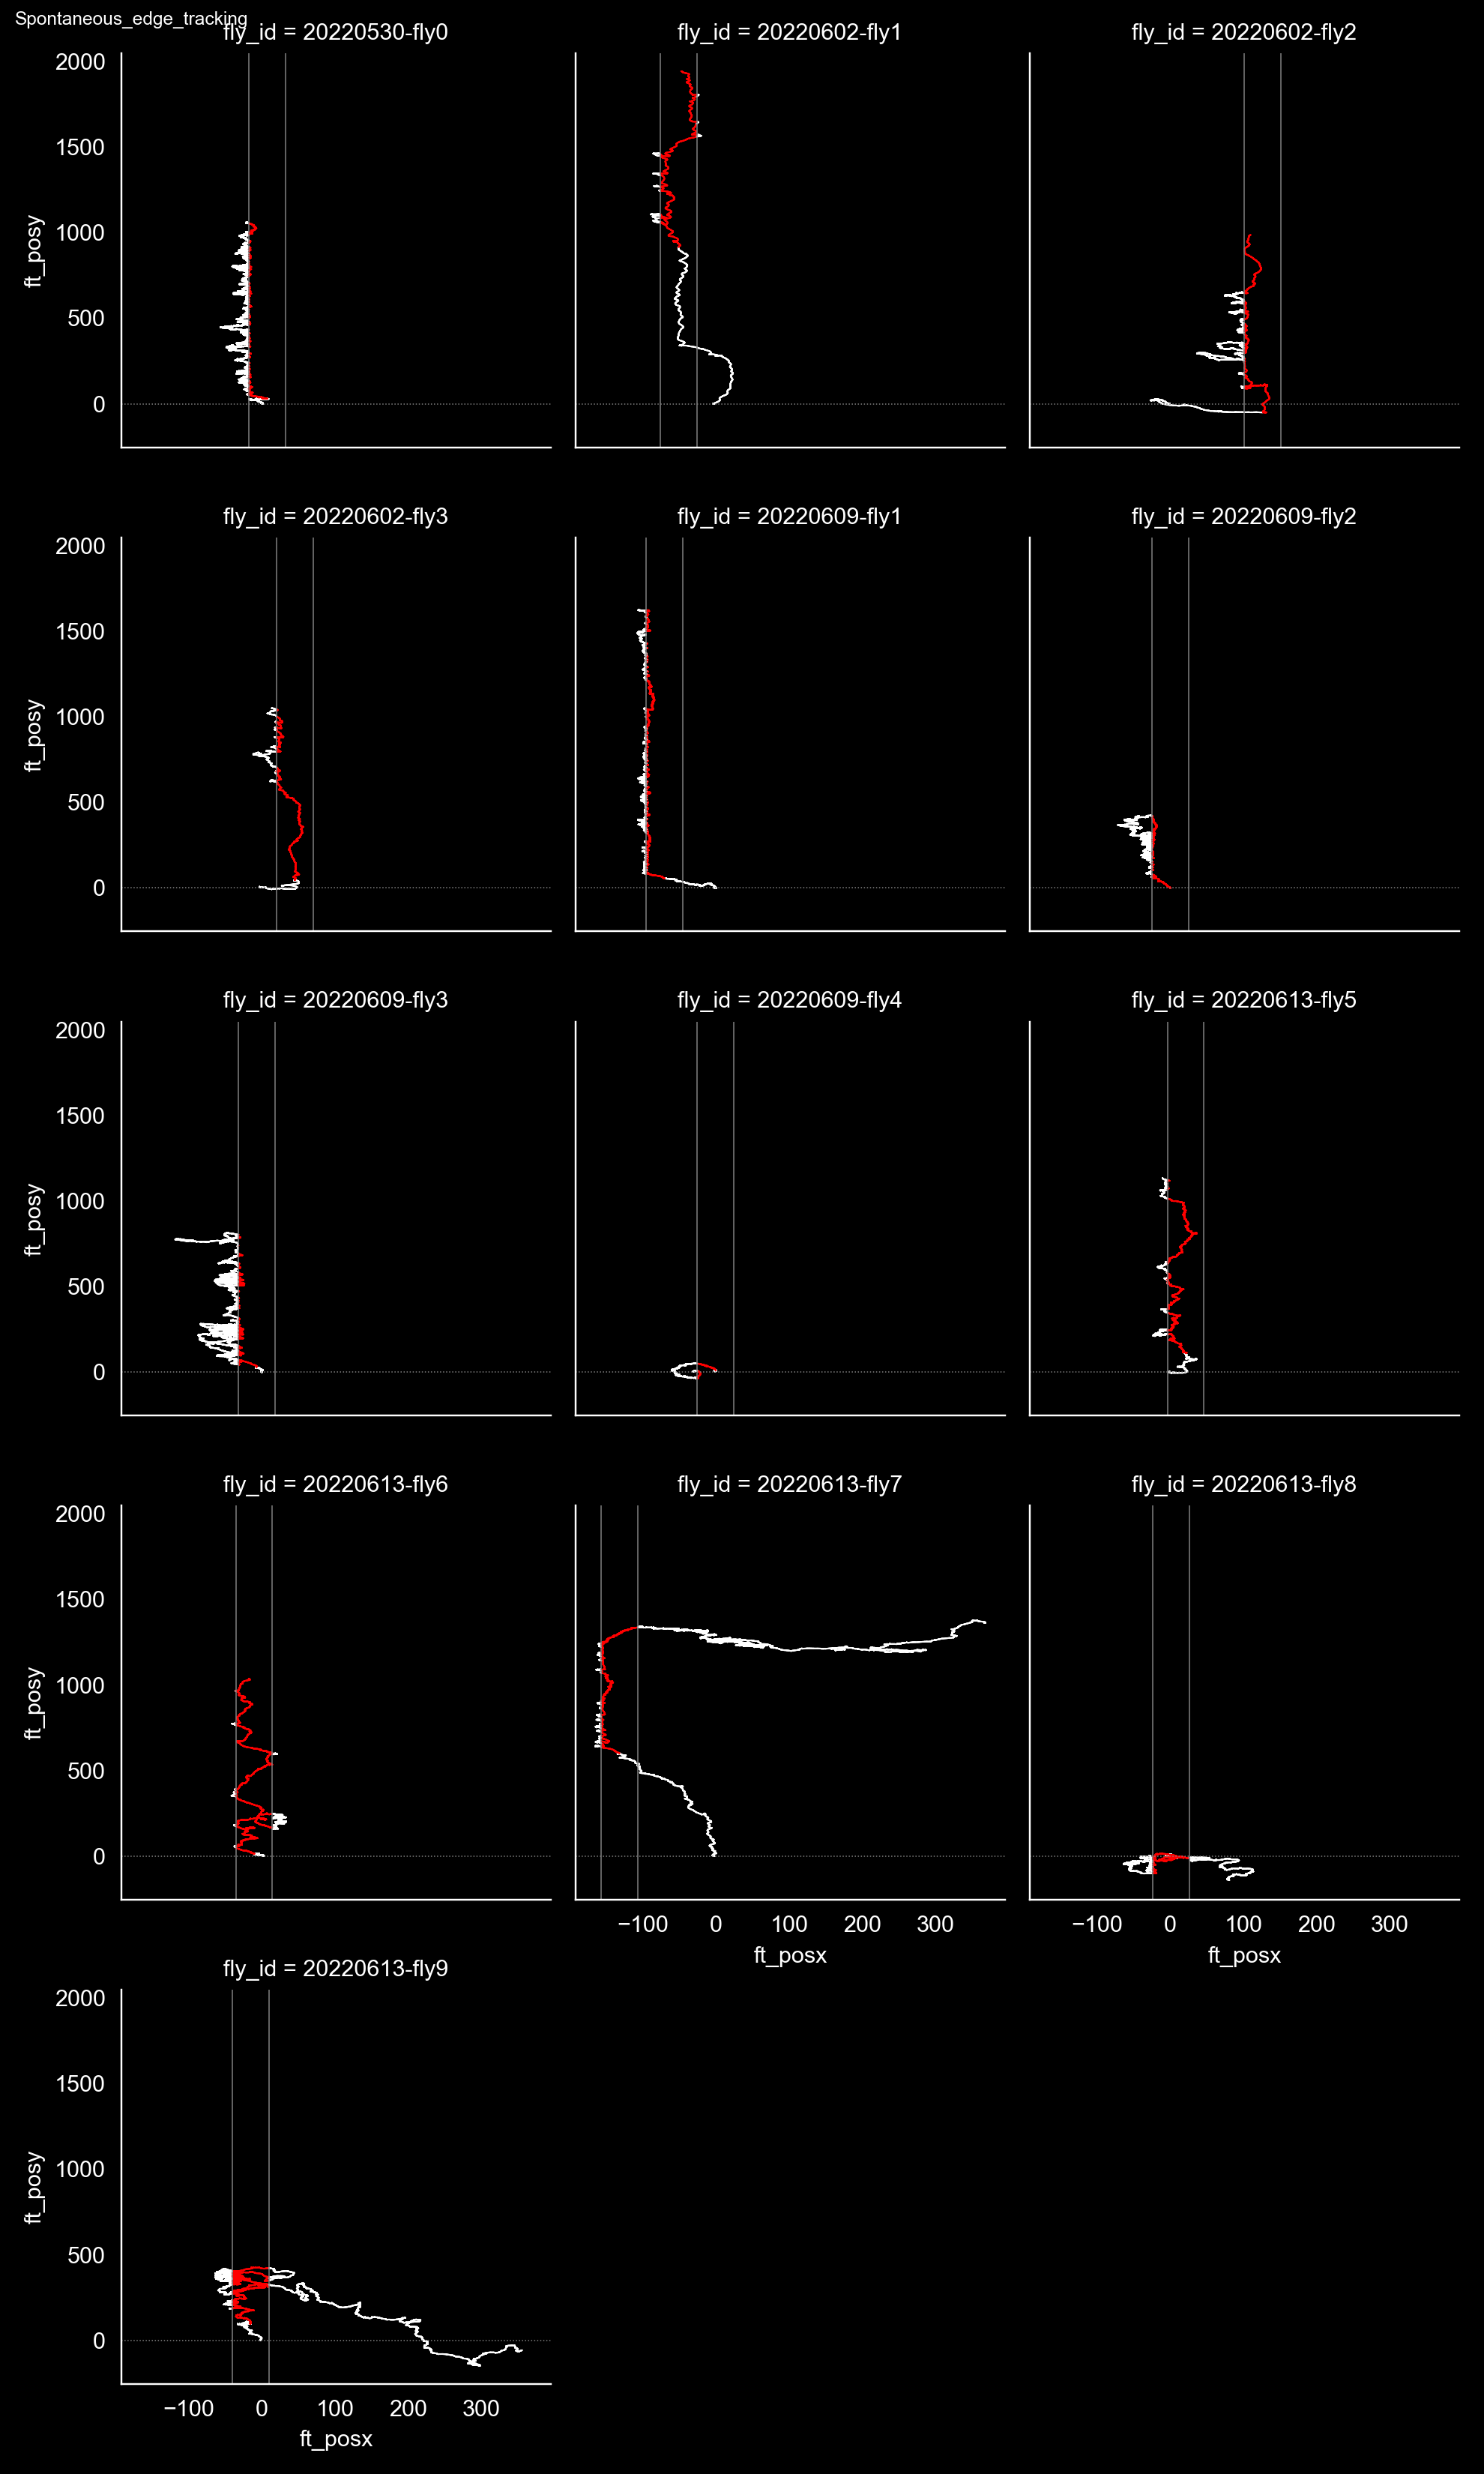

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_11506/981970154.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for fly_id, currdf in plotdf.groupby(['fly_id']):


In [21]:
# plot
hue_varname='instrip'
palette={True: 'r', False: 'w'}
start_at_odor = True
odor_width=50
odor_lc='lightgray'
odor_lw=0.5
conds=['spontaneoustracking'] #'odor', 'reinforced']
# -----
plotdf = df0.copy()
g = sns.FacetGrid(plotdf,  col='fly_id', col_wrap=3)
g.map_dataframe(sns.scatterplot, x="ft_posx", y="ft_posy", hue=hue_varname,
               s=0.5, edgecolor='none', palette=palette) #, palette=palette)
pl.show()
util.label_figure(g.fig, experiment)

# add odor corridor to facet grid
for fly_id, currdf in plotdf.groupby(['fly_id']):
    cond_ix = conds.index(cond)
    fly_ix = fly_ids.index(fly_id)
    ax = g.axes[fly_ix]
    odor_xmin, odor_xmax = odor_borders[fly_id]
    butil.plot_odor_corridor(ax, odor_xmin=odor_xmin, odor_xmax=odor_xmax)

figname = 'all_odor_v_reinforced_by_fly'
pl.savefig(os.path.join(save_dir, '{}.png'.format(figname))) #, dpi=dpi)


In [ ]:
importlib.reload(butil)

In [22]:
df0['condition'] ='odor'
DF = butil.process_df(df0, conditions=['odor'])

In [23]:
fly_id = fly_ids[0]
fly_id
#df = DF[(DF['fly_id']==fly_id) & (DF['condition']=='odor')].copy()
df_ = DF[DF['fly_id']==fly_id].copy()
#df_ = DF[(DF['fly_id']==fly_id)].copy()


In [29]:
smooth_window=11
rdp_epsilon=0.5
for varname in ['ft_posx', 'ft_posy']:
    df_ = butil.smooth_traces(df_, varname=varname, window_size=smooth_window)
df_ = butil.add_rdp_by_bout(df_, epsilon=rdp_epsilon)

<IPython.core.display.Javascript object>


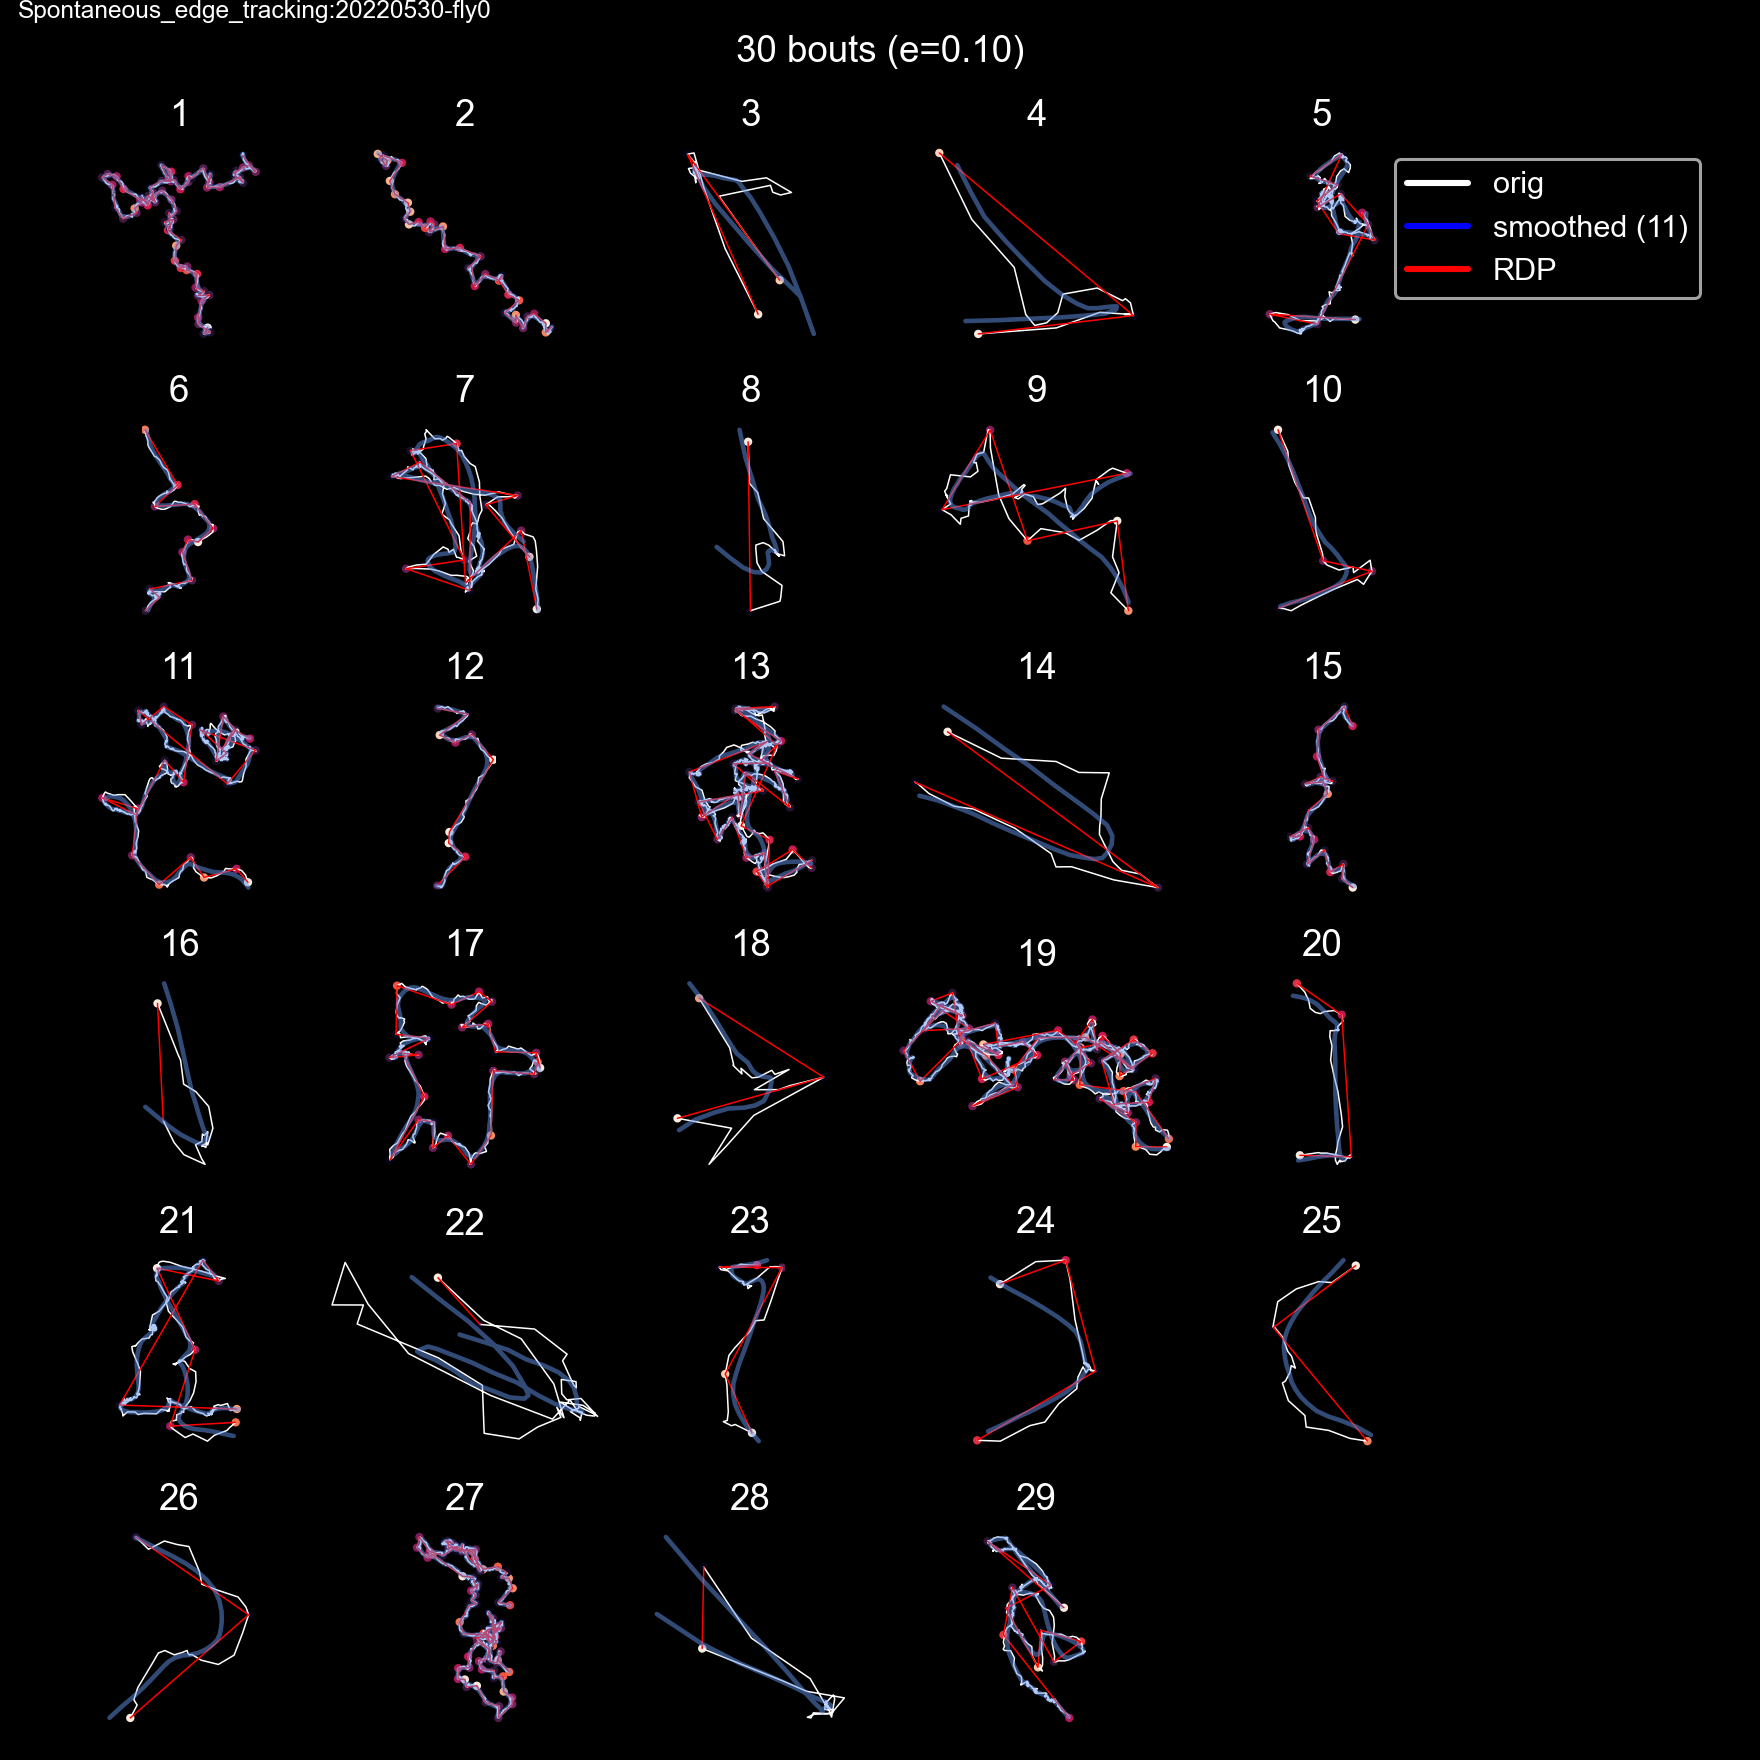

all_odor_v_reinforced_by_fly


In [34]:
nr=6
nc=5
nbouts_plot=nc*nr
fig, axes = pl.subplots(nr, nc, figsize=(8,8))
for ax, bnum in zip(axes.flat, np.arange(1, nr*nc)):
    b_ = df_[(df_['condition']=='odor') & (df_['boutnum']==bnum)].copy()
    ax.plot(b_['ft_posx'], b_['ft_posy'], 'w', alpha=1, lw=0.5)
    ax.plot(b_[b_['rdp_posx']]['ft_posx'], b_[b_['rdp_posy']]['ft_posy'], 'r', alpha=1, lw=0.5)

    ax.plot(b_['smoothed_ft_posx'], b_['smoothed_ft_posy'], 'cornflowerblue', alpha=0.5)
    #ax.plot(b_[b_['rdp_posx']]['ft_posx'], b_[b_['rdp_posy']]['ft_posy'], 'r', alpha=0.5)
    ax.scatter(b_[b_['rdp_posx']]['ft_posx'], b_[b_['rdp_posy']]['ft_posy'], 
               c=b_[b_['rdp_posy']]['speed'], alpha=1, s=3)
    ax.set_title(bnum)
for ax in axes.flat:
    ax.set_aspect('equal')
    ax.axis('off')
legh = [mpl.lines.Line2D([0], [0], color='w', lw=2, label='orig'),
        mpl.lines.Line2D([0], [0], color='b', lw=2, label='smoothed ({})'.format(smooth_window)),
       mpl.lines.Line2D([0], [0], color='r', lw=2, label='RDP')]
axes.flat[nc-1].legend(handles=legh, bbox_to_anchor=(1,1), loc='upper left')
fig.suptitle('{} bouts (e={:.2f})'.format(nbouts_plot, rdp_epsilon))
util.label_figure(fig, '{}:{}'.format(experiment, fly_id))
pl.tight_layout()

#figname = 'rdp_epsilon{}_{}'.format(str(rdp_epsilon).replace('.', 'p'), fly_id)
print(figname)
#pl.savefig(os.path.join(save_dir, '{}.png'.format(figname)))